# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = fires_dt.drop(columns=['area'])  # All columns except the target
Y = fires_dt['area']  # Target column

# Perform the train-test split with a 70-30% ratio and a random state of 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Check the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (361, 12)
X_test shape: (156, 12)
Y_train shape: (361,)
Y_test shape: (156,)


In [4]:
train_data = (X_train, Y_train)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


In [6]:
# Define numerical and categorical columns
numerical_columns = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_columns = ['month', 'day']

# Pipeline for numerical features
numerical_pipeline = Pipeline([
        ('scaler', RobustScaler())
])

# Pipeline for categorical features
categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])


In [7]:
# Preproc1: Scaling and one-hot encoding without transformations
preproc1 = ColumnTransformer([
    ('num_transforms', numerical_pipeline, numerical_columns),
    ('cat_transforms', categorical_pipeline, categorical_columns)
])

preproc1

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [8]:
# Preproc 2

# Log transformations are used to stabilize variance, make data more normally distributed, and reduce skewness.


# # Example: Applying different non-linear transformations
# log_transform = FunctionTransformer(np.log1p)        # Log transformation
# sqrt_transform = FunctionTransformer(np.sqrt)        # Square root transformation
# yeo_johnson = PowerTransformer(method='yeo-johnson') # Yeo-Johnson transformation

# Here, applied a log transformation to 'dc' and 'dmc' as an example
# The FunctionTransformer with np.log1p applies a log transformation to dc and dmc

from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Pipeline for numerical features
num_pipe = Pipeline([
        ('scaler', RobustScaler())
])

# Pipeline for categorical features
cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])


# Preproc2: Scaling and one-hot encoding with non-linear transformations
preproc2 = ColumnTransformer([
    ('num_transforms', num_pipe, numerical_columns),
    ('log_transform', FunctionTransformer(np.log1p, validate = True), ['dc', 'dmc']),
    ('cat_transforms', cat_pipe, categorical_columns)
])

preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('log_transform',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['dc', 'dmc']),
                                ('cat_transforms',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import cross_validate


# Baseline and advanced regressor setup
baseline_regressor = LinearRegression()
advanced_regressor = RandomForestRegressor(random_state=42)

# Define scoring metrics for regression
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']


In [10]:
# Pipeline A = preproc1 + baseline

Pipeline_A = Pipeline([
    ('preprocessing', preproc1),   # Use preproc1 or preproc2 from previous step
    ('regressor', baseline_regressor)
])

Pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [13]:
# Pipeline A


# Perform cross-validation with 5 folds on training data
cv_results_A = cross_validate(Pipeline_A, X_train, Y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Display the cross-validation results
import pandas as pd
cv_results_A_df = pd.DataFrame(cv_results_A)#.assign(experiment = 1)

# calculate mean of each metric
mean_cv_result_A = cv_results_A_df.mean()
print(mean_cv_result_A)

# # Calculate class predictions
# Y_pred_A = Pipeline_A.predict(X_test)


fit_time                            0.024464
score_time                          0.023472
test_neg_mean_squared_error     -2521.658763
train_neg_mean_squared_error    -2196.608623
test_neg_mean_absolute_error      -20.098627
train_neg_mean_absolute_error     -18.170748
test_r2                            -0.333879
train_r2                            0.068137
dtype: float64


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
# Pipeline B = preproc2 + baseline

Pipeline_B = Pipeline([
    ('preprocessing', preproc2),   # Use preproc1 or preproc2 from previous step
    ('regressor', baseline_regressor)
])

Pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['dc', 'dmc']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [15]:
# Pipeline B
# Fit and perform cross-validation with 5 folds on training data
cv_results_B = cross_validate(Pipeline_B, X_train, Y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Display the cross-validation results
import pandas as pd
cv_results_B_df = pd.DataFrame(cv_results_B)#.assign(experiment = 2)

# calculate mean of each metric
mean_cv_result_B = cv_results_B_df.mean()
print(mean_cv_result_B)

# # Display cross-validation results
# print("Cross-validation results:")
# for metric in scoring_metrics:
#     print(f"{metric} - Train: {cv_results_B[f'train_{metric}'].mean()}, Test: {cv_results_B[f'test_{metric}'].mean()}")

# # Fitted the Pipeline_A on the training data
# Pipeline_B.fit(X_train, Y_train)

# # Calculate class predictions
# Y_pred_B = Pipeline_B.predict(X_test)


fit_time                            0.026927
score_time                          0.017876
test_neg_mean_squared_error     -2527.322719
train_neg_mean_squared_error    -2192.352656
test_neg_mean_absolute_error      -20.149405
train_neg_mean_absolute_error     -18.159392
test_r2                            -0.346602
train_r2                            0.070228
dtype: float64


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
# Pipeline C = preproc1 + advanced model
Pipeline_C = Pipeline([
    ('preprocessing', preproc1),   # Use preproc1 or preproc2 from previous step
    ('regressor', advanced_regressor)
])
Pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [17]:
# Pipeline_C

# Fit and perform cross-validation with 5 folds on training data
cv_results_C = cross_validate(Pipeline_C, X_train, Y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Display the cross-validation results
import pandas as pd
cv_results_C_df = pd.DataFrame(cv_results_C)#.assign(experiment = 3)

# calculate mean of each metric
mean_cv_result_C = cv_results_C_df.mean()
print(mean_cv_result_C)

# # Calculate class predictions
# Y_pred_C = Pipeline_C.predict(X_test)


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


fit_time                            0.492482
score_time                          0.023081
test_neg_mean_squared_error     -3077.184708
train_neg_mean_squared_error     -413.531186
test_neg_mean_absolute_error      -22.143183
train_neg_mean_absolute_error      -7.937696
test_r2                            -0.898469
train_r2                            0.820129
dtype: float64


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [18]:
# Pipeline D = preproc2 + advanced model

Pipeline_D = Pipeline([
    ('preprocessing', preproc2),   # Use preproc1 or preproc2 from previous step
    ('regressor', advanced_regressor)
])

Pipeline_D

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['dc', 'dmc']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [19]:
#Tuning Pipeline_D

# Fit and perform cross-validation with 5 folds on training data
cv_results_D = cross_validate(Pipeline_D, X_train, Y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Display the cross-validation results
import pandas as pd
cv_results_D_df = pd.DataFrame(cv_results_D)#.assign(experiment = 4)

# calculate mean of each metric
mean_cv_result_D = cv_results_D_df.mean()
print(mean_cv_result_D)

# Calculate class predictions
#Y_pred_D = Pipeline_D.predict(X_test)


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


fit_time                            0.576941
score_time                          0.021107
test_neg_mean_squared_error     -3174.582858
train_neg_mean_squared_error     -416.174238
test_neg_mean_absolute_error      -21.852962
train_neg_mean_absolute_error      -7.939784
test_r2                            -1.020236
train_r2                            0.819080
dtype: float64


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
result_summary = {
    'Pipeline A' : mean_cv_result_A ,
    'Pipeline B' : mean_cv_result_B ,
    'Pipeline C' : mean_cv_result_C ,
    'Pipeline D' : mean_cv_result_D

}

In [21]:
result_df = pd.DataFrame(result_summary)
result_df

,Pipeline A,Pipeline B,Pipeline C,Pipeline D
fit_time,0.024464,0.026927,0.492482,0.576941
score_time,0.023472,0.017876,0.023081,0.021107
test_neg_mean_squared_error,-2521.658763,-2527.322719,-3077.184708,-3174.582858
train_neg_mean_squared_error,-2196.608623,-2192.352656,-413.531186,-416.174238
test_neg_mean_absolute_error,-20.098627,-20.149405,-22.143183,-21.852962
train_neg_mean_absolute_error,-18.170748,-18.159392,-7.937696,-7.939784
test_r2,-0.333879,-0.346602,-0.898469,-1.020236
train_r2,0.068137,0.070228,0.820129,0.819080


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [22]:
#Tuning Pipeline_A

# Define parameter grid for grid search
Pipeline_A_params = {
    # Example: no parameters for linear regression here, but could tune regularization if using Ridge or Lasso
    }

# Define scoring metrics for cross-validation
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Grid search for baseline regressor (optional, for more complex baseline models like Ridge/Lasso)
Pipe_A_grid_search = GridSearchCV(Pipeline_A, 
                                    Pipeline_A_params, 
                                    cv=5, scoring= scoring_metrics,
                                    refit = "neg_mean_squared_error" # Refit using the model with the best MSE
)


In [23]:
# Fit grid search to the training data
Pipe_A_grid_search.fit(X_train, Y_train)

c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={}, refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [24]:
# Access best parameters and best score for the refit metric
best_params_A = Pipe_A_grid_search.best_params_
best_score_A = Pipe_A_grid_search.best_score_

print("Best Parameters:", best_params_A)
print("Best Score (neg_mean_squared_error):", best_score_A)


Best Parameters: {}
Best Score (neg_mean_squared_error): -2521.6587628345146


In [25]:
# Pipeline B

# Define parameter grid for grid search
Pipeline_B_params = {
    # Example: no parameters for linear regression here, but could tune regularization if using Ridge or Lasso
    }

# Define scoring metrics for cross-validation
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Grid search for baseline regressor (optional, for more complex baseline models like Ridge/Lasso)
Pipe_B_grid_search = GridSearchCV(Pipeline_B,
                                         Pipeline_B_params, 
                                         cv=5, scoring= scoring_metrics,
                                         refit = "neg_mean_squared_error" # Refit using the model with the best MSE
    )

# Fit grid search to the training data
Pipe_B_grid_search.fit(X_train, Y_train)



c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('log_transform',
                                                                         FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                             validate=True),
                                                                         ['dc',
                                                                          'dmc']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={}, refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [26]:
# Access best parameters and best score for the refit metric
best_params_B = Pipe_B_grid_search.best_params_
best_score_B = Pipe_B_grid_search.best_score_

print("Best Parameters:", best_params_B)
print("Best Score (neg_mean_squared_error):", best_score_B)


Best Parameters: {}
Best Score (neg_mean_squared_error): -2527.3227192346594


In [27]:
# Pipeline C
# Define parameter grid for grid search
Pipeline_C_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf' : [1, 2, 4]
}
 
# Define scoring metrics for cross-validation
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Grid search for advance regressor (Random Forest Regressor)
Pipe_C_grid_search = GridSearchCV(Pipeline_C, 
                                    Pipeline_C_params, 
                                    cv=5, scoring= scoring_metrics,
                                    refit = "neg_mean_squared_error" # Refit using the model with the best MSE
    )


In [28]:
# Fit grid search to the training data
Pipe_C_grid_search.fit(X_train, Y_train)


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [10, 20, None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [29]:
# Access best parameters and best score for the refit metric
best_params_C = Pipe_C_grid_search.best_params_
best_score_C = Pipe_C_grid_search.best_score_

print("Best Parameters:", best_params_C)
print("Best Score (neg_mean_squared_error):", best_score_C)


Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best Score (neg_mean_squared_error): -2532.9379725954805


In [30]:
# Pipeline D

# Define parameter grid for grid search
Pipeline_D_params = {
    'regressor__n_estimators': [10, 50, 100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf' : [1, 2, 4]
}

# Define scoring metrics for cross-validation
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Grid search for advance regressor 
Pipe_D_grid_search = GridSearchCV(Pipeline_D, 
                                    Pipeline_D_params,
                                     cv=5, scoring= scoring_metrics, 
                                     refit = "neg_mean_squared_error" # Refit using the model with the best MSE
)


In [31]:
# Fit grid search to the training data
Pipe_D_grid_search.fit(X_train, Y_train)


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('log_transform',
                                                                         FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                             validate=True),
                                                                         ['dc',
                                                                          'dmc']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('...
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [10, 50, 100, 200, 500]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [32]:
# Access best parameters and best score for the refit metric
best_params_D = Pipe_D_grid_search.best_params_
best_score_D = Pipe_D_grid_search.best_score_

print("Best Parameters:", best_params_D)
print("Best Score (neg_mean_squared_error):", best_score_D)


Best Parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best Score (neg_mean_squared_error): -2532.228581670096


In [33]:
Best_score_summary = {
    'Pipeline A' : best_score_A ,
    'Pipeline B' : best_score_B ,
    'Pipeline C' : best_score_C ,
    'Pipeline D' : best_score_D

}
Best_score_summary

{'Pipeline A': -2521.6587628345146,
 'Pipeline B': -2527.3227192346594,
 'Pipeline C': -2532.9379725954805,
 'Pipeline D': -2532.228581670096}

In [34]:
Best_result_summary = {
    'Pipeline A': {'best_params': best_params_A, 'best_score': best_score_A},
    'Pipeline B': {'best_params': best_params_B, 'best_score': best_score_B},
    'Pipeline C': {'best_params': best_params_C, 'best_score': best_score_C},
    'Pipeline D': {'best_params': best_params_D, 'best_score': best_score_D}
}

Best_result_summary
# # To print the summary of best parameters and scores
# for pipeline, result in Best_result_summary.items():
#     print(f"{pipeline} - Best Parameters: {result['best_params']}, Best Score: {result['best_score']}")


{'Pipeline A': {'best_params': {}, 'best_score': -2521.6587628345146},
 'Pipeline B': {'best_params': {}, 'best_score': -2527.3227192346594},
 'Pipeline C': {'best_params': {'regressor__max_depth': 10,
   'regressor__min_samples_leaf': 4,
   'regressor__min_samples_split': 10,
   'regressor__n_estimators': 200},
  'best_score': -2532.9379725954805},
 'Pipeline D': {'best_params': {'regressor__max_depth': None,
   'regressor__min_samples_leaf': 4,
   'regressor__min_samples_split': 10,
   'regressor__n_estimators': 200},
  'best_score': -2532.228581670096}}

In [35]:
# Convert the Best_result_summary dictionary to a DataFrame
Best_result_summary_df = pd.DataFrame.from_dict(Best_result_summary, orient='index')

# Display the DataFrame
print(Best_result_summary_df)

                                                  best_params   best_score
Pipeline A                                                 {} -2521.658763
Pipeline B                                                 {} -2527.322719
Pipeline C  {'regressor__max_depth': 10, 'regressor__min_s... -2532.937973
Pipeline D  {'regressor__max_depth': None, 'regressor__min... -2532.228582


# Evaluate

+ Which model has the best performance?

Conclution: 

From this result, we can draw a few key insights regarding the performance and tuning of each pipeline:

Best Performing Pipeline:

Pipeline A has the best score (i.e., the least negative MSE) at -2521.66, followed closely by Pipeline B at -2527.32.
Pipeline C and Pipeline D perform slightly worse with scores of -2532.94 and -2532.23, respectively.
Conclusion: Pipelines A and B may perform better on this dataset even without parameter tuning. This could indicate that the default configurations or simpler models in these pipelines are well-suited to the data.

Effect of Hyperparameter Tuning:

Pipelines C and D have customized parameters for the RandomForestRegressor, while A and B do not (their best_params fields are empty).
Conclusion: The hyperparameter tuning did not significantly improve performance for Pipelines C and D in this case.

Parameter Insights:

Pipelines C and D use RandomForestRegressor with n_estimators=200, min_samples_leaf=4, and min_samples_split=10. However, Pipeline C limits the max_depth to 10, whereas Pipeline D allows for an unrestricted depth (indicated by None).
This small difference in max_depth does not appear to yield a significant performance difference, as shown by the close scores of Pipelines C and D.
Conclusion: Allowing deeper trees (as in Pipeline D) might slightly improve performance compared to limiting the depth (as in Pipeline C). However, the impact is minor, indicating that the model may not be very sensitive to this parameter on this dataset.

Possible Next Steps:

Consider testing other algorithms or adding feature engineering steps if the current model complexity is insufficient to capture patterns in the data.
Investigate why Pipelines A and B perform relatively well without hyperparameter tuning, which might involve understanding their default configurations or simpler structure.

In summary, Pipelines A and B show better performance without tuning, suggesting that the tuned hyperparameters in Pipelines C and D do not provide a notable advantage.


# Export

+ Save the best performing model to a pickle file.

In [36]:
import pickle

# Assuming Pipeline_A is the trained model with the best performance
best_model = Pipeline_A  

# Save the model to a pickle file
with open('best_model_pipeline_A.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best performing model saved as 'best_model_pipeline_A.pkl'")


Best performing model saved as 'best_model_pipeline_A.pkl'


In [37]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [38]:
preproc1

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['month', 'day'])])

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [ ]:
# Check the steps in your pipeline to identify the preprocessing step name
print(best_model.named_steps)


In [42]:
Pipeline_A.fit(X_train,Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [56]:
# Transform both X_train and X_test using the preprocessing pipeline
X_train_transformed = best_model.named_steps['preprocessing'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

# Check if the number of features match
print(f"Number of features in transformed X_train: {X_train_transformed.shape[1]}")
print(f"Number of features in transformed X_test: {X_test_transformed.shape[1]}")

# Ensure the SHAP explainer is correctly initialized
import shap

# Transform X_test using the preprocessing step in your pipeline
data_transform = best_model.named_steps['preprocessing'].transform(X_test)


# Initialize SHAP explainer for the Linear Regression model
explainer = shap.Explainer(
    best_model.named_steps['regressor'], 
    X_train_transformed,  # Background data (X_train transformed)
    feature_names=best_model.named_steps['preprocessing'].get_feature_names_out()
)

# Check if we can get expected_value and intercept from the model
print(f"Model expected value (intercept): {explainer.expected_value}")


Number of features in transformed X_train: 29
Number of features in transformed X_test: 29
Model expected value (intercept): 12.033308531928727


In [59]:
# Calculate SHAP values for the transformed X_test data
shap_values = explainer(X_test_transformed)



In [62]:
shap_values

.values =
array([[ 3.51390134, -0.33977502,  0.13339246, ..., -0.97909195,
         0.08639903,  0.18477745],
       [ 6.25913676, -0.33977502, -0.13608726, ..., -0.97909195,
        -0.8735902 ,  0.18477745],
       [ 9.00437218, -0.93587154, -0.03809463, ..., -0.97909195,
         0.08639903,  0.18477745],
       ...,
       [ 6.25913676, -0.93587154, -0.01604629, ..., -0.97909195,
         0.08639903, -1.66299704],
       [ 9.00437218, -0.93587154,  0.04029947, ..., -0.97909195,
         0.08639903,  0.18477745],
       [ 9.00437218, -0.93587154, -0.01359648, ..., -0.97909195,
         0.08639903,  0.18477745]])

.base_values =
array([12.03330853, 12.03330853, 12.03330853, 12.03330853, 12.03330853,
       12.03330853, 12.03330853, 12.03330853, 12.03330853, 12.03330853,
       12.03330853, 12.03330853, 12.03330853, 12.03330853, 12.03330853,
       12.03330853, 12.03330853, 12.03330853, 12.03330853, 12.03330853,
       12.03330853, 12.03330853, 12.03330853, 12.03330853, 12.03330853,
 

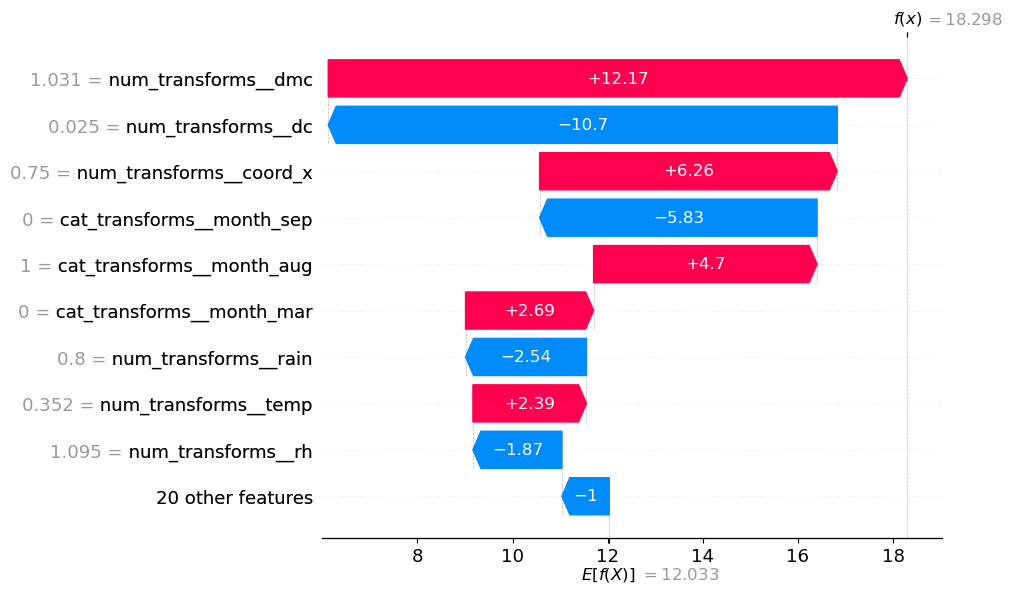

In [ ]:
# Visualize SHAP values 
# The waterfall plot below shows the contribution of each feature to an individual prediction. 
#Only the most important features are shown, while the least important features are grouped together at the bottom of the chart

shap.plots.waterfall(shap_values[1])

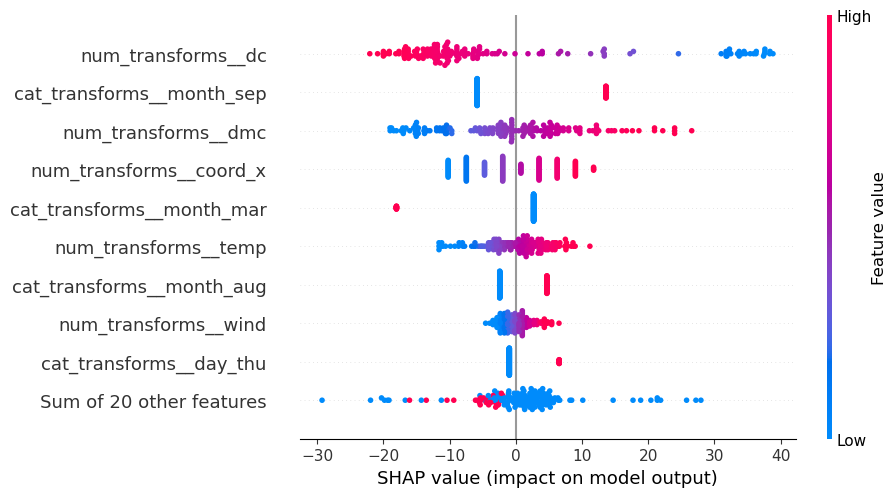

In [ ]:
#+ Beeswarm plots summarize the behaviour of the model across all items in the sample.

shap.plots.beeswarm(shap_values)

*(Answer here.)*
Top Features: The features with the highest impact on predictions (listed at the top) include num_transforms__dc, cat_transforms__month_sep, and num_transforms__dmc. These have the largest spread of SHAP values, meaning they have a significant influence on the model output.

SHAP values to the right of zero (positive) increase the prediction. For example, high values of num_transforms__dc tend to have a positive impact, as represented by red dots to the right.
SHAP values to the left of zero (negative) decrease the prediction. For instance, low values of num_transforms__dmc are shown in blue and tend to push predictions down.

Red indicates high values, and blue indicates low values. For num_transforms__dc, high values have a strong positive impact, whereas low values of num_transforms__dmc tend to have a negative impact.
Features like cat_transforms__month_sep and cat_transforms__month_mar likely represent binary encoded categorical variables. For example, cat_transforms__month_sep shows mostly positive SHAP values, meaning being in September has a generally positive impact on the prediction.

The most important features, such as num_transforms__dc and num_transforms__dmc, might be essential for the model, while the "Sum of 20 other features" at the bottom indicates less impactful variables. If considering feature removal, we can focus on those features with minimal spread and low SHAP values across observations.



## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.